In [1]:
import os
import pickle
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Dict

from cl_explain.metrics.ablation import compute_auc

In [2]:
RESULT_PATH = "/projects/leelab/cl-explainability/results"
SUPERPIXEL_ATTRIBUTION_METHODS = ["kernel_shap"]
SEED_LIST = [123, 456, 789, 42, 91]

In [3]:
def get_eval_filename(
    corpus_size: int,
    explanation_name: str,
    foil_size: int,
    explicand_size: int,
    attribution_name: str,
    superpixel_dim: int,
    removal: str,
    blur_strength: float,
    eval_superpixel_dim: int,
    eval_foil_size: int,
    take_attribution_abs: bool,
) -> str:
    """Get eval filename."""
    eval_filename = "eval_results"
    eval_filename += f"_explicand_size={explicand_size}"
    if "corpus" in explanation_name:
        eval_filename += f"_corpus_size={corpus_size}"
    if "contrastive" in explanation_name:
        eval_filename += f"_foil_size={foil_size}"
    if attribution_name in SUPERPIXEL_ATTRIBUTION_METHODS:
        eval_filename += f"_superpixel_dim={superpixel_dim}"
    eval_filename += f"_removal={removal}"
    if removal == "blurring":
        eval_filename += f"_blur_strength={blur_strength:.1f}"
    eval_filename += f"_eval_superpixel_dim={eval_superpixel_dim}"
    eval_filename += f"_eval_foil_size={eval_foil_size}"
    if take_attribution_abs:
        eval_filename += "_abs"
    eval_filename += ".pkl"
    return eval_filename


def get_mean_curves(outputs, curve_kind) -> Tuple[List[torch.Tensor], int]:
    available_curve_kinds = ["insertion", "deletion"]
    assert curve_kind in available_curve_kinds, (
        f"curve_kind={curve_kind} is not one of {available_curve_kinds}!"
    )
    target_list = [key for key in outputs.keys()]
    eval_name_list = (
        outputs[target_list[0]]["eval_model_names"]
        + outputs[target_list[0]]["eval_measure_names"]
    )
    eval_mean_curve_dict = {}
    for j, eval_name in enumerate(eval_name_list):
        
        curve_list = []
        num_features = None

        for target, output in outputs.items():
            target_curve_list = (
                output[f"model_{curve_kind}_curves"]
                + output[f"measure_{curve_kind}_curves"]
            )
            curve_list.append(target_curve_list[j])
            num_features = output[f"{curve_kind}_num_features"]
        
        curves = torch.cat(curve_list)
        mean_curve = curves.mean(dim=0).cpu()
        eval_mean_curve_dict[eval_name] = mean_curve
        
    return eval_mean_curve_dict, num_features


def format_eval_name(name):
    format_map = {
        "corpus_cosine_similarity": "Cosine similarity to corpus",
        "contrastive_corpus_cosine_similarity": "Cosine similarity to corpus vs. foil",
        "corpus_majority_prob": "Predicted probability of corpus majority",
        "explicand_pred_prob": "Predicted probability of explicand",
        "explicand_rep_shift": "Representation shift of explicand",
    }
    return format_map[name]


def format_explanation_name(name):
    format_map = {
        "self_weighted": "Labe-Free",
        "contrastive_self_weighted": "Contrastive",
        "corpus": "Corpus",
        "contrastive_corpus": "Contrastive Corpus",
    }
    return format_map[name]


def format_attribution_name(name):
    format_map = {
        "gradient_shap": "Gradient Shap",
        "int_grad": "Integrated Gradient",
        "vanilla_grad": "Vanilla Gradient",
        "random_baseline": "Random",
    }
    return format_map[name]

In [4]:
dataset = "imagenet"
encoder = "simclr_x1"

explicand_size = 25
removal = "blurring"
blur_strength = 5.0
superpixel_dim = 1
eval_superpixel_dim = 1
foil_size = 1000
corpus_size = 100
eval_foil_size = 1000
take_attribution_abs = False

explanation_list = [
    "self_weighted",
    "contrastive_self_weighted",
    "corpus",
    "contrastive_corpus",
]
explanation_colors = {
    "self_weighted": "tab:green",
    "contrastive_self_weighted": "tab:orange",
    "corpus": "tab:blue",
    "contrastive_corpus": "tab:red",
}
attribution_list = ["random_baseline", "int_grad"]

insertion_curve_dict = {}
deletion_curve_dict = {}
insertion_num_features = None
deletion_num_features = None

for explanation in explanation_list:
    insertion_curve_dict[explanation] = {}
    deletion_curve_dict[explanation] = {}
    for attribution in attribution_list:
        insertion_curve_dict[explanation][attribution] = {}
        deletion_curve_dict[explanation][attribution] = {}
        
        for seed in SEED_LIST:
            eval_filename = get_eval_filename(
                corpus_size=corpus_size,
                explanation_name=explanation,
                foil_size=foil_size,
                explicand_size=explicand_size,
                attribution_name=attribution,
                superpixel_dim=superpixel_dim,
                removal=removal,
                blur_strength=blur_strength,
                eval_superpixel_dim=eval_superpixel_dim,
                eval_foil_size=eval_foil_size,
                take_attribution_abs=take_attribution_abs,
            )
            with open(
                os.path.join(
                    RESULT_PATH,
                    dataset,
                    encoder,
                    f"{explanation}_{attribution}",
                    f"{seed}",
                    eval_filename,
                ),
                "rb",
            ) as handle:
                outputs = pickle.load(handle)
            seed_insertion_curve_dict, insertion_num_features = get_mean_curves(
                outputs, "insertion"
            )
            seed_deletion_curve_dict, deletion_num_features = get_mean_curves(
                outputs, "deletion"
            )
            for eval_name in seed_insertion_curve_dict.keys():
                
                if eval_name not in insertion_curve_dict[explanation][attribution].keys():
                    insertion_curve_dict[explanation][attribution][eval_name] = []
                    
                if eval_name not in deletion_curve_dict[explanation][attribution].keys():
                    deletion_curve_dict[explanation][attribution][eval_name] = []
                    
                insertion_curve_dict[explanation][attribution][eval_name].append(
                    seed_insertion_curve_dict[eval_name]
                )
                deletion_curve_dict[explanation][attribution][eval_name].append(
                    seed_deletion_curve_dict[eval_name]
                )
        
        insertion_curve_dict[explanation][attribution] = {
            eval_name: torch.stack(curve_list)
            for eval_name, curve_list
            in insertion_curve_dict[explanation][attribution].items()
        }
        deletion_curve_dict[explanation][attribution] = {
            eval_name: torch.stack(curve_list)
            for eval_name, curve_list
            in deletion_curve_dict[explanation][attribution].items()
        }

In [5]:
all_curve_dict = {
    "insertion": insertion_curve_dict,
    "deletion": deletion_curve_dict,
}
num_features_dict = {
    "insertion": insertion_num_features,
    "deletion": deletion_num_features,
}
eval_name_list = [
    key for key
    in insertion_curve_dict[explanation_list[0]][attribution_list[0]].keys()
]

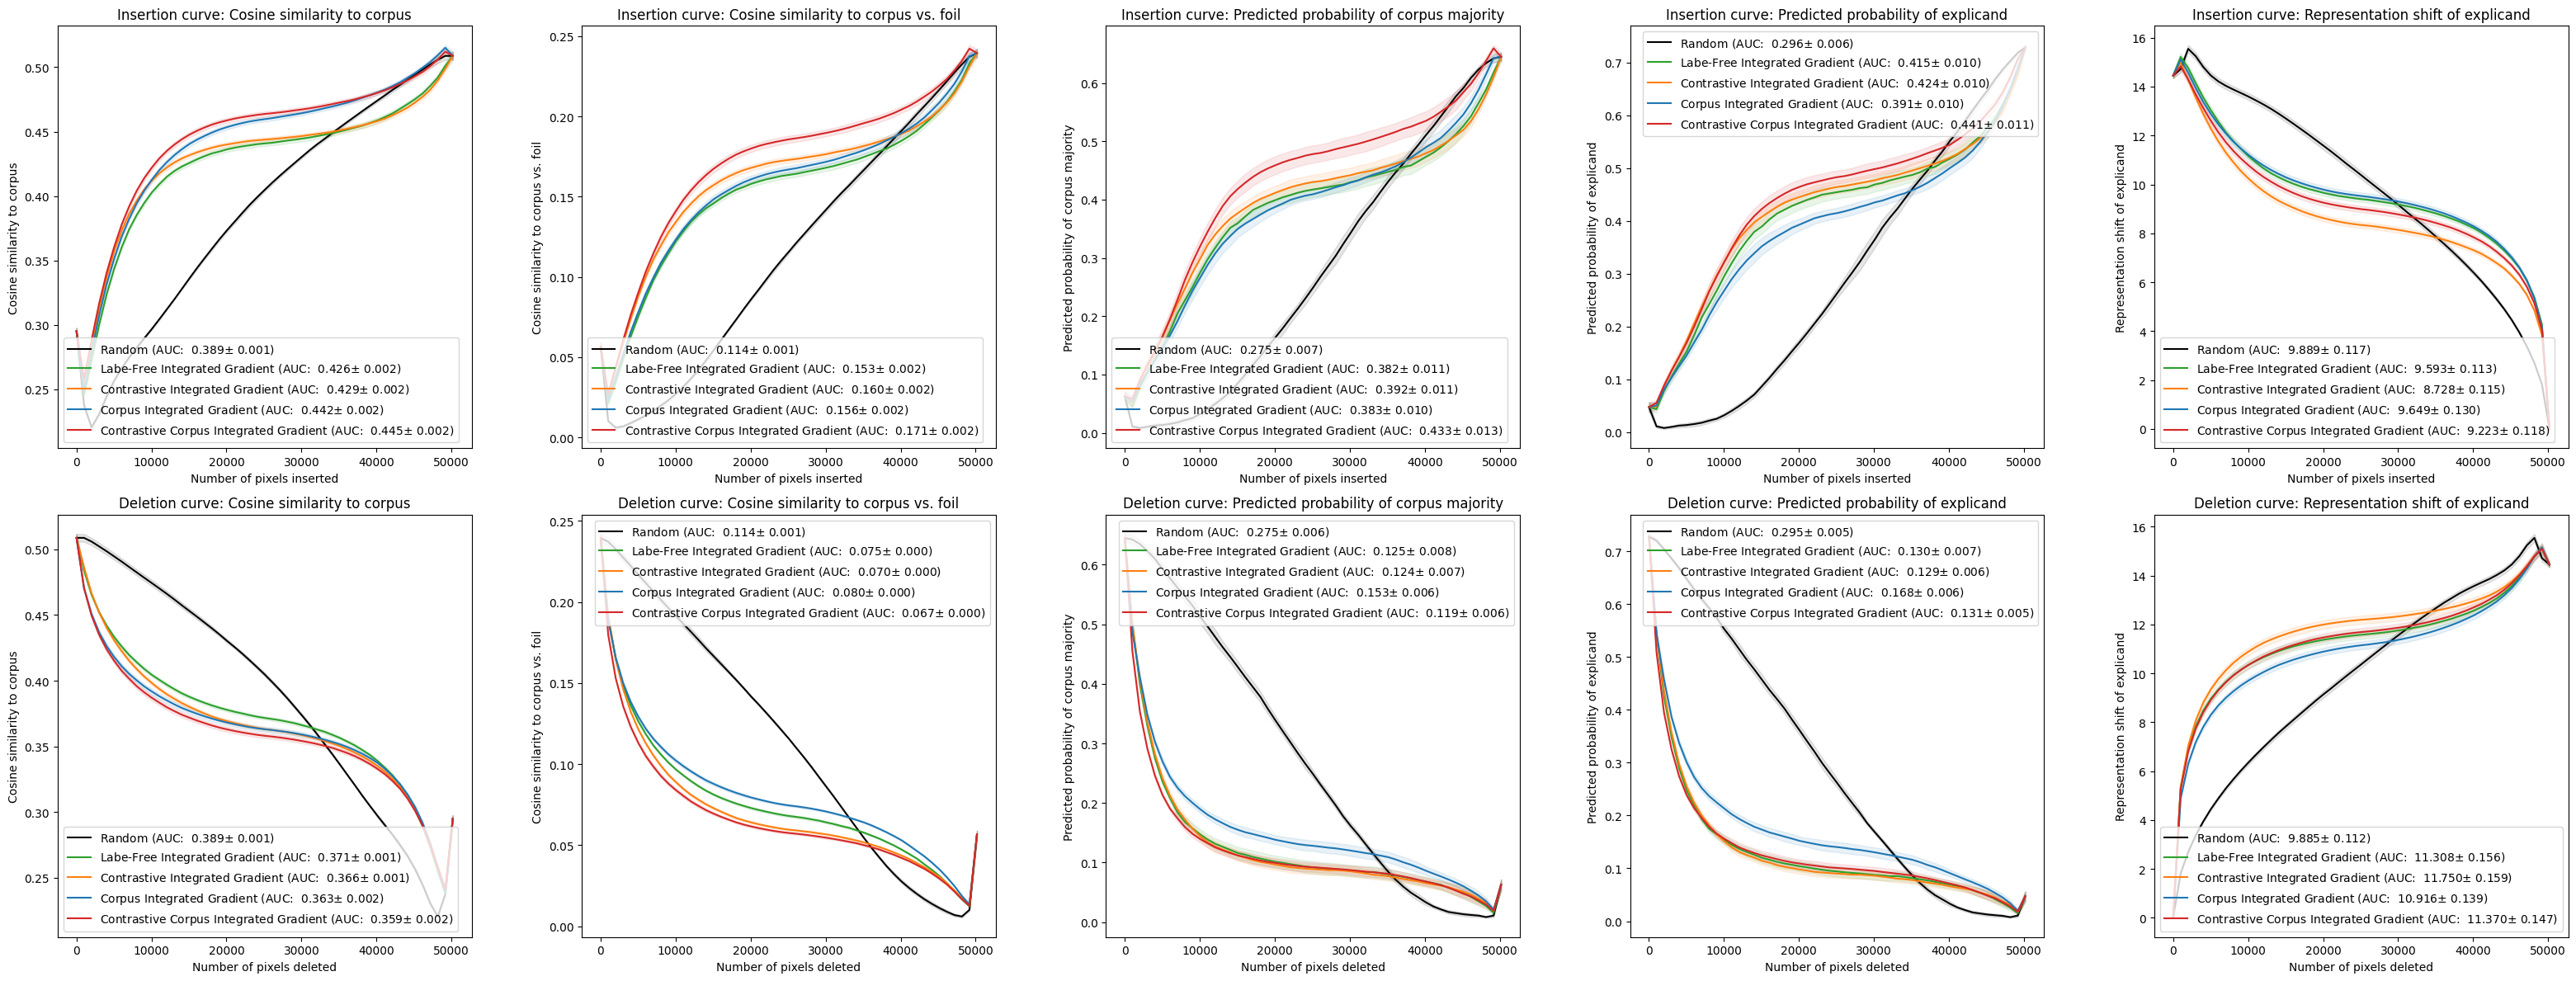

In [6]:
fig, axes = plt.subplots(ncols=len(eval_name_list), nrows=2, figsize=(32, 12))

for explanation in explanation_list:
    for attribution in attribution_list:
        make_plot = True
        if (
            attribution == "random_baseline"
            and explanation != explanation_list[0]
        ):
            make_plot = False
        if attribution == "random_baseline":
            method_name = "Random"
        else:
            method_name = (
                format_explanation_name(explanation)
                + " "
                + format_attribution_name(attribution)
            )
        for j, eval_name in enumerate(eval_name_list):
            formatted_eval_name = format_eval_name(eval_name)
            
            for curve_kind, curve_dict in all_curve_dict.items():
                curves = curve_dict[explanation][attribution][eval_name]
                curve_mean = curves.mean(dim=0).cpu().numpy()
                curve_std = curves.std(dim=0).cpu().numpy()
                curve_ci = curve_std / np.sqrt(len(SEED_LIST)) * 1.96
                aucs = compute_auc(curves, num_features_dict[curve_kind])
                auc_mean = aucs.mean(dim=0).cpu().numpy()
                auc_std = aucs.std(dim=0).cpu().numpy()
                auc_ci = auc_std / np.sqrt(len(SEED_LIST)) * 1.96
                
                if curve_kind == "insertion":
                    axis_row = 0
                    title_prefix = "Insertion curve:"
                    xlabel = "Number of pixels inserted"
                else:
                    axis_row = 1
                    title_prefix = "Deletion curve:"
                    xlabel = "Number of pixels deleted"
                    
                if attribution == "random_baseline":
                    color = "black"
                else:
                    color = explanation_colors[explanation]
                
                auc_text = f"AUC: {auc_mean: .3f}" + r"$\pm$" + f"{auc_ci: .3f}"
                    
                if make_plot:
                    axes[axis_row, j].plot(
                        num_features_dict[curve_kind],
                        curve_mean,
                        label=method_name + f" ({auc_text})",
                        color=color,
                    )
                    axes[axis_row, j].fill_between(
                        num_features_dict[curve_kind],
                        curve_mean - curve_ci,
                        curve_mean + curve_ci,
                        alpha=0.1,
                        color=color,
                    )
                    axes[axis_row, j].set_title(f"{title_prefix} {formatted_eval_name}")
                    axes[axis_row, j].set_xlabel(xlabel)
                    axes[axis_row, j].set_ylabel(f"{formatted_eval_name}")
                    axes[axis_row, j].legend()
                
plt.tight_layout()